# Data preparation

## Data loading

In [1]:
import re
import time
import warnings
from pprint import PrettyPrinter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from IPython.display import display
from joblib import dump, load
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

RANDOM_STATE = 12345
RMSE_THRESHOLD = 2500
TRAIN_SET_SIZE = 0.6
TEST_SET_SIZE = 0.4
CV_FOLDS = 10
N_ITER = 10
SCORER = "neg_root_mean_squared_error"

warnings.filterwarnings("ignore")

In [2]:
# Loading the data to a DataFrame
autos_data = pd.read_csv("datasets/autos.csv")

Let's make sure that we have correctly loaded data into a DataFrame.

In [3]:
autos_data.sample(7, random_state=RANDOM_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
18734,2016-04-04 13:36:58,16900,bus,2010,auto,150,viano,150000,4,gasoline,mercedes_benz,no,2016-04-04 00:00:00,0,60326,2016-04-05 12:18:31
141787,2016-03-07 17:57:08,15500,other,2011,manual,143,1er,40000,5,gasoline,bmw,no,2016-03-07 00:00:00,0,35083,2016-04-06 20:19:15
37523,2016-03-24 09:37:02,3600,sedan,2004,manual,125,astra,150000,12,petrol,opel,no,2016-03-24 00:00:00,0,13627,2016-03-24 10:38:57
194192,2016-03-15 09:49:03,8990,sedan,2007,auto,224,c_klasse,150000,9,gasoline,mercedes_benz,no,2016-03-15 00:00:00,0,58135,2016-03-18 02:17:06
110210,2016-03-29 23:43:52,2500,other,1994,manual,68,transporter,150000,9,gasoline,volkswagen,no,2016-03-29 00:00:00,0,24598,2016-04-02 12:45:46
63295,2016-03-07 12:55:48,11000,wagon,2010,auto,177,5er,150000,10,gasoline,bmw,no,2016-03-07 00:00:00,0,6237,2016-04-04 02:16:33
299143,2016-03-24 17:48:59,1200,small,2003,NaN,58,clio,150000,3,petrol,renault,no,2016-03-24 00:00:00,0,25551,2016-03-24 17:48:59


**Summary**

At this stage, we have imported all required libraries with required functions and data structures and managed to successfully read the data and correctly load it into a separate DataFrame.

## Exploring data

In [4]:
autos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

We observe the following. We have data on 354,369 objects (vehicles) with various attributes and characteristics, which are of `int64` and `object` data types. We also see that the data contains information on the following 16 characteristics of automobiles:

<table>
<thead>
<tr><th>Features</th><th>Description</th></tr>
</thead>
<tbody>
<tr><td><b>DateCrawled</b></td><td><i>Date when the data was downloaded from the database</i></td></tr>
<tr><td><b>Price</b></td><td><i>Price of a vehicle (in euros)</i></td></tr>
<tr><td><b>VehicleType</b></td><td><i>Car body type</i></td></tr>
<tr><td><b>RegistrationYear</b></td><td><i>Year of vehicle registration</i></td></tr>
<tr><td><b>Gearbox</b></td><td><i>Type of gearbox</i></td></tr>
<tr><td><b>Power</b></td><td><i>Power of a vehicle (in hp)</i></td></tr>
<tr><td><b>Model</b></td><td><i>Model of a vehicle</i></td></tr>
<tr><td><b>Kilometer</b></td><td><i>Mileage of a vehicle (in km)</i></td></tr>
<tr><td><b>RegistrationMonth</b></td><td><i>Month of vehicle registration</i></td></tr>
<tr><td><b>FuelType</b></td><td><i>Type of fuel used by a vehicle</i></td></tr>
<tr><td><b>Brand</b></td><td><i>Brand of a vehicle</i></td></tr>
<tr><td><b>Repaired</b></td><td><i>Indicator of previously performed repairs</i></td></tr>
<tr><td><b>DateCreated</b></td><td><i>Date when the data entry was created</i></td></tr>
<tr><td><b>Number of Pictures</b></td><td><i>Number of photos of a vehicle available</i></td></tr>
<tr><td><b>PostalCode</b></td><td><i>User's postal code</i></td></tr>
<tr><td><b>LastSeen</b></td><td><i>Date of a user's last activity</i></td></tr>
</tbody>
</table>

Furthermore, the presence of missing values in the data is clearly traced, which will have to be dealt with at the stage of data preprocessing. We also see that the column names do not correspond to the standard of column names, which can be handled efficiently and quickly, which will be shown in the preprocessing section.

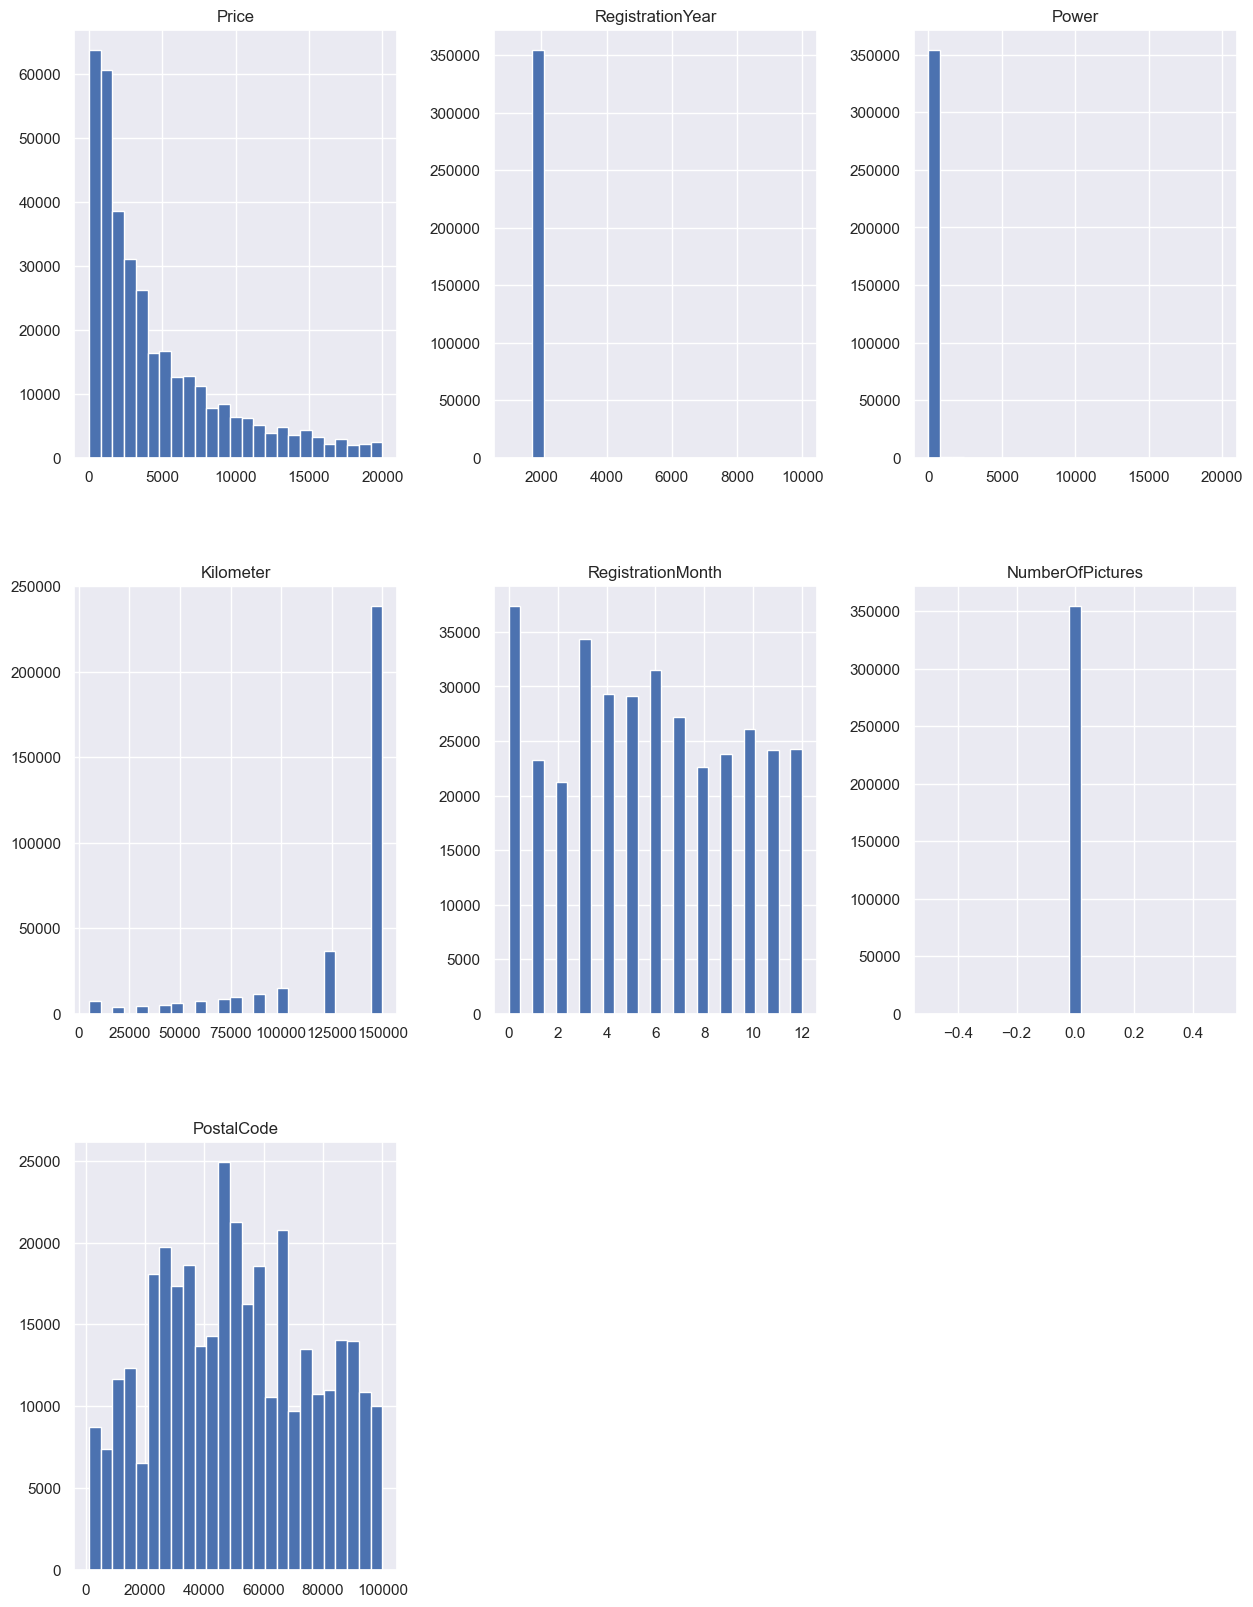

In [5]:
# Setting the style of plots
sns.set_theme(style="darkgrid")

# Visualization of numeric columns
autos_data.hist(bins=25, figsize=(15, 20))
plt.show()

In [6]:
display(autos_data.describe().round(1).T)

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.7,4514.2,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.2,90.2,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.1,189.9,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.2,37905.3,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.7,3.7,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.7,25783.1,1067.0,30165.0,49413.0,71083.0,99998.0


Perhaps the first thing that is quite visible is the presence of anomalies in the `RegistrationYear` column, since it contains the values of the registration year that are either too high or too low to be true. Anomalies are also visible in the `Price` column (a large number of zero prices), `RegistrationMonth` (presence of 13 months, instead of 12), as well as `Power` (zero power for most objects).

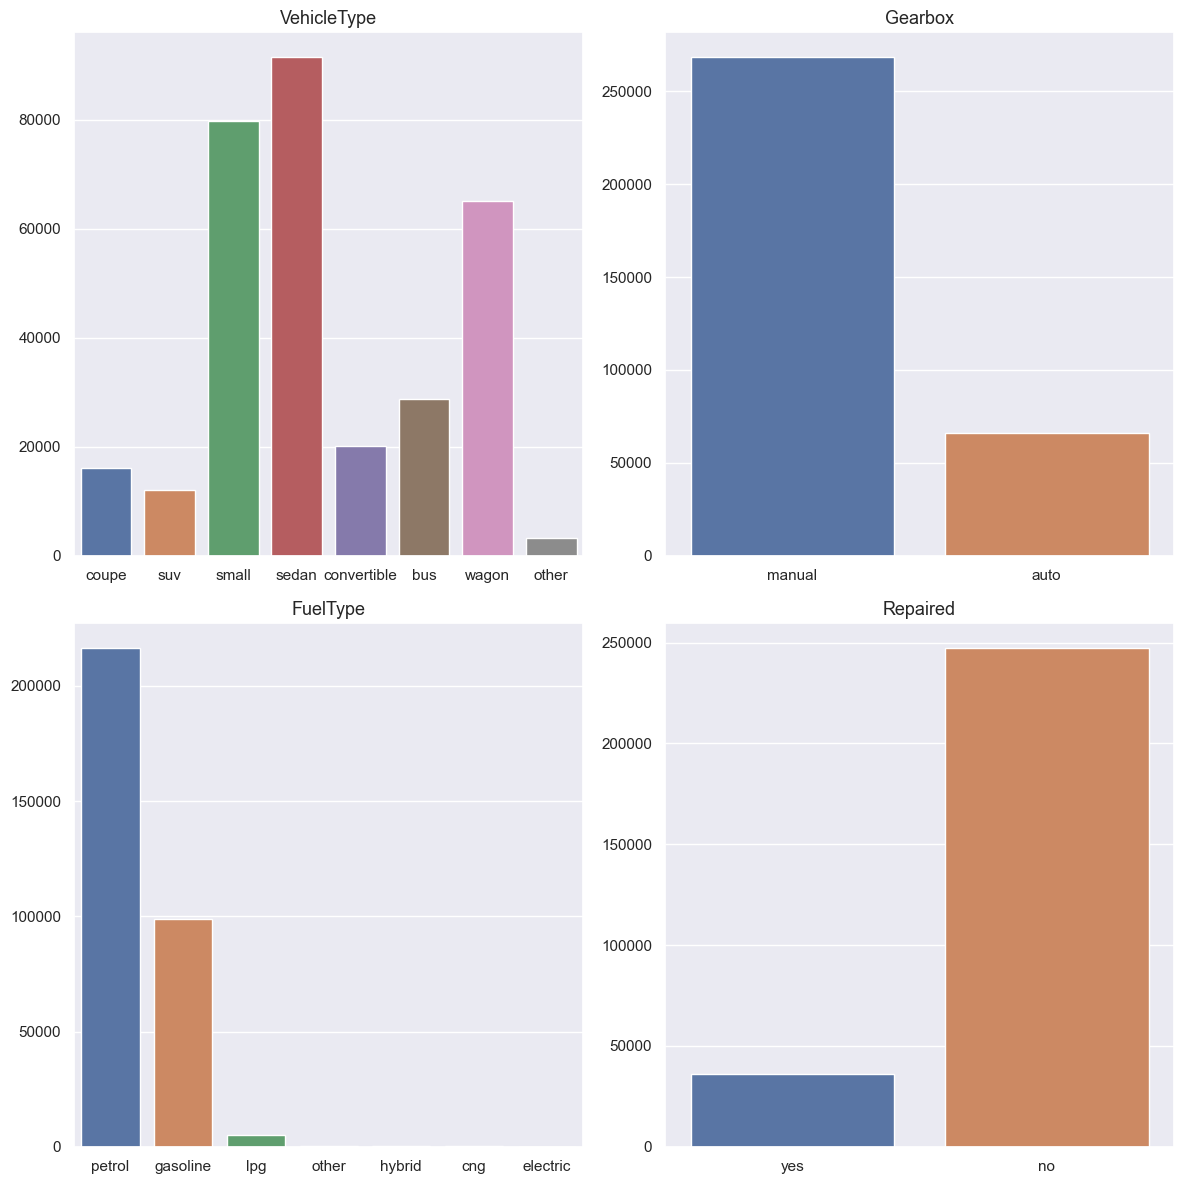

In [7]:
# Selecting categorical columns with less than 10 unique values
cat_cols = autos_data.select_dtypes(include="object").columns.to_list()
cat_cols_to_plot = [col for col in cat_cols if len(autos_data[col].unique()) < 10]

# Visualization of categorical columns
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.reshape(
    4,
)
for col, ax in zip(cat_cols_to_plot, axes):
    f = sns.countplot(data=autos_data, x=col, ax=ax)
    f.set(xlabel=None, ylabel=None)
    f.set_title(col, fontsize=13)
plt.tight_layout()
plt.show()

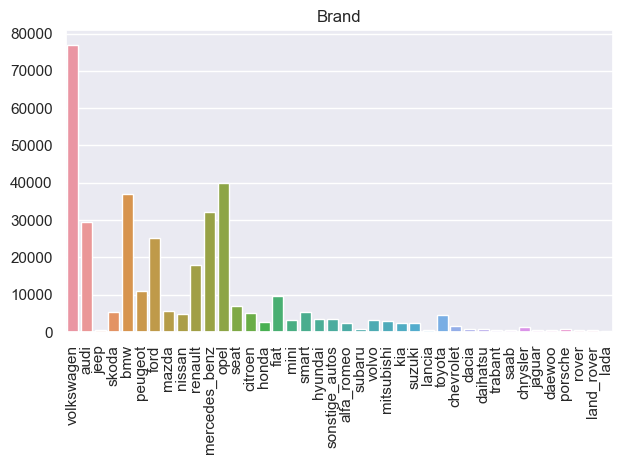

In [8]:
# Visualization of "Brand" column
fig = sns.countplot(data=autos_data, x="Brand")
fig.set(xlabel=None, ylabel=None)
plt.title("Brand")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Summary**

This stage was needed to conduct an initial review of the data, as a result of which we studied and visualized the data depending on the type of data in the DataFrame columns. We were also able to detect the presence of not only missing values, but also anomalies in some columns. We also saw that the column names can be changed for more convenient work with data.

## Data preprocessing

### Column names

In [9]:
print(f"Old column names: {autos_data.columns.to_list()}\n")

# Changing column names to a convenient format
autos_data = autos_data.rename(
    columns=lambda col_name: re.sub("(?<=[a-z])(?=[A-Z])", "_", col_name).lower()
)

print(f"New column names: {autos_data.columns.to_list()}")

Old column names: ['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']

New column names: ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']


### Anomalies

In order to get rid of anomalous values we can write a function called `clean_data()` that will filter the DataFrame, hence deleting anomalies.

In [10]:
def clean_data(data, column, lower_val, upper_val):
    """Filters out values in a specific columns of a DataFrame.

    Parameters
    ----------
    data : DataFrame
        DataFrame with information on automobile vehicles.
    column : str
        DataFrame column by which filtering should be done.
    lower_val : int
        The lowest value of the filtering region.
    upper_val : int
        The highest value of the filtering region.

    Returns
    -------
    DataFrame
        Object with its values in a specific column filtered
        out according to `lower_val` and `upper_val`.
    """
    # Determining the indexes of rows without anomalies
    filtering_indices = data[column].between(lower_val, upper_val)

    # Removing anomalies from data
    data_filtered = data[filtering_indices].reset_index(drop=True)

    # Displaying the filtering result
    data_size_new = data_filtered.shape[0]
    data_size_old = data.shape[0]
    anomalies_num = data_size_old - data_size_new
    anomalies_percentage = anomalies_num / data_size_old
    print(f"DataFrame size (prior to filtering): {data_size_old:,}")
    print(f"DataFrame size (after filtering): {data_size_new:,}")
    print(f"Objects filtered out: {anomalies_num:,} ({anomalies_percentage:.1%})")

    return data_filtered

#### Registration year

Let's look at the values of the year of registration in order to try to locate potential anomalous values.

In [11]:
reg_year_unique = autos_data["registration_year"].sort_values().unique()
print(reg_year_unique)

[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]


There are indeed some years that seem to be too far off the reasonable bounds of registration year values. We will need only relevant information for training and predictions so we will take year of 1970 as the lower bound and 2016 as upper bound (2016 is in fact the year when the information was donwloaded from the database, seen in `date_crawled` column).

In [12]:
# Choosing reasonable time period
year_upper = pd.to_datetime(
    autos_data["date_crawled"], format="%Y-%m-%d %H:%M:%S"
).dt.year.max()
year_lower = 1970
print(f"Relevant period: {year_lower}-{year_upper}")

Relevant period: 1970-2016


We should now get rid of data pertaining to anomalous registration years, which we will do using user-defined `clean_data()` function.

In [13]:
# Getting rid of anomalies in "registration_year" column
autos_data = clean_data(
    data=autos_data,
    column="registration_year",
    lower_val=year_lower,
    upper_val=year_upper,
)

DataFrame size (prior to filtering): 354,369
DataFrame size (after filtering): 338,501
Objects filtered out: 15,868 (4.5%)


In [14]:
year_lower <= np.min(autos_data["registration_year"]) <= year_upper

True

In [15]:
year_lower <= np.max(autos_data["registration_year"]) <= year_upper

True

#### Vehicle price

Next, we can consider unique values of the target denoting prices of automobiles.

In [16]:
print(autos_data["price"].sort_values().unique())

[    0     1     2 ... 19998 19999 20000]


There is a number of prices that seem absurd so we will leave only those objects in the data which have a price of at least 100 EUR.

In [17]:
# Choosing plausible prices
price_upper = np.max(autos_data["price"])
price_lower = 100
print(f"Price range: {price_lower:,}-{price_upper:,} EUR")

Price range: 100-20,000 EUR


In [18]:
# Getting rid of anomalous prices
autos_data = clean_data(
    data=autos_data,
    column="price",
    lower_val=price_lower,
    upper_val=price_upper,
)

DataFrame size (prior to filtering): 338,501
DataFrame size (after filtering): 326,252
Objects filtered out: 12,249 (3.6%)


In [19]:
price_lower <= np.min(autos_data["price"]) <= price_upper

True

In [20]:
price_lower <= np.max(autos_data["price"]) <= price_upper

True

#### Power

During visualizations we also noticed some anomalies in `power` column.

In [21]:
print(autos_data["power"].sort_values().unique())

[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   111   112   113   114   115   116   117   118   119
   120   121   122   123   124   125   126   127   128   129   130   131
   132   133   134   135   136   137   138   139   140   141   142   143
   144   145   146   147   148   149   150   151   152   153   154   155
   156   157   158   159   160   161   162   163   

In [22]:
# Choosing reasonable power bounds
power_upper = 1000
power_lower = 20
print(f"Power range: {power_lower:,}-{power_upper:,} HP")

Power range: 20-1,000 HP


In [23]:
# Getting rid of anomalous power values
autos_data = clean_data(
    data=autos_data,
    column="power",
    lower_val=power_lower,
    upper_val=power_upper,
)

DataFrame size (prior to filtering): 326,252
DataFrame size (after filtering): 294,409
Objects filtered out: 31,843 (9.8%)


In [24]:
power_lower <= np.min(autos_data["power"]) <= power_upper

True

In [25]:
power_lower <= np.max(autos_data["power"]) <= power_upper

True

We have managed to process anomalous values in the DataFrame so let's print out the range of values that we will henceforth consider.

In [26]:
display(autos_data.describe().loc[["min", "max"]].astype(int).T)

,min,max
price,100,20000
registration_year,1970,2016
power,20,1000
kilometer,5000,150000
registration_month,0,12
number_of_pictures,0,0
postal_code,1067,99998


### Deleting irrelevant infomation

The data contains a certain number of columns that will not be particularly informative for solving the task at hand. Such columns include:

* `date_crawled`
* `registration_year`
* `registration_month`
* `date_created`
* `number_of_pictures`
* `postal code`
* `last_seen`

Let's get rid of these columns.

In [27]:
irrelevant_cols = [
    "date_crawled",
    "registration_year",
    "registration_month",
    "date_created",
    "number_of_pictures",
    "postal_code",
    "last_seen",
]
autos_data.drop(columns=irrelevant_cols, axis=1, inplace=True)
display(autos_data.tail())

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired
294404,5250,NaN,auto,150,159,150000,NaN,alfa_romeo,no
294405,3200,sedan,manual,225,leon,150000,petrol,seat,yes
294406,1199,convertible,auto,101,fortwo,125000,petrol,smart,no
294407,9200,bus,manual,102,transporter,150000,gasoline,volkswagen,no
294408,3400,wagon,manual,100,golf,150000,gasoline,volkswagen,NaN


### Missing values

In order to compute missing values in the DataFrame, we will write a function called `identify_missing_values()` for calculating the number and share of `NaN` values in the data.

In [28]:
def identify_missing_values(data):
    """Performs missing values computation.

    Function computes a number and share of missing values
    in DataFrame columns which have NaN-values present
    and displays data types of such columns.

    Parameters
    ----------
    data : DataFrame
        DataFrame which needs to be checked for missing values.

    Returns
    -------
    DataFrame or None
        DataFrame with column names/their data types, number of
        missing values and shares of NaN-values in such columns,
        or None if no missing values have been found.
    """
    # Verifying the presence of missing values
    miss_vals_num = data.isnull().sum()[data.isnull().sum() > 0]
    if miss_vals_num.empty:
        return None

    # Creating a table with numbers of missing values
    cols = {"missing_count": miss_vals_num.values}
    nans_df = pd.DataFrame(data=cols, index=miss_vals_num.index).sort_values(
        by="missing_count", ascending=False
    )

    # Adding shares of missing values
    nans_df["missing_fraction"] = nans_df["missing_count"] / data.shape[0]
    nans_df["missing_fraction"] = nans_df["missing_fraction"].round(4)

    # Adding data types
    nans_df["dtype"] = data[nans_df.index].dtypes
    nans_df = nans_df[["dtype", "missing_count", "missing_fraction"]]

    return nans_df

In [29]:
identify_missing_values(data=autos_data)

,dtype,missing_count,missing_fraction
repaired,object,42304,0.1437
fuel_type,object,15270,0.0519
vehicle_type,object,10792,0.0367
model,object,10706,0.0364
gearbox,object,5215,0.0177


We see that only 5 columns have at least 1 missing value and those columns are all categorical. For solving the problem, we will resort to filling in missing values in `object` columns with the most frequent category in the data which will be done later when specifying preprocessing pipelines.

### Removing duplicates

After having removed irrelevant columns from the DataFrame, we have created an opportunity for us to verify the data for the presence of identical rows. Let's test this assumption and delete such rows from the data.

In [30]:
print(f"DataFrame size (before duplicates deletion): {autos_data.shape[0]:,}")

# Checking and deleting identical rows
duplicates_num = autos_data.duplicated().sum()
duplicates_share = duplicates_num / autos_data.shape[0]
autos_data.drop_duplicates(inplace=True)

print(f"DataFrame size (after duplicates deletion): {autos_data.shape[0]:,}")
print(f"Duplicates removed: {duplicates_num:,} ({duplicates_share:.1%})")

DataFrame size (before duplicates deletion): 294,409
DataFrame size (after duplicates deletion): 230,770
Duplicates removed: 63,639 (21.6%)


### Splitting data

Now, we will single out a target column from the rest of the features and then carry out data split into training and test sets.

In [31]:
# Separating features from target
features = autos_data.drop(["price"], axis=1)
target = autos_data["price"]

In [32]:
# Splitting data into training and test sets
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=TEST_SET_SIZE,
    random_state=RANDOM_STATE,
)

Let's now check if we have managed to preserve the correct proportions when we have split the data into sets.

In [33]:
# Computing shares of training set
features_train_share = np.round(features_train.shape[0] / autos_data.shape[0], 2)
target_train_share = np.round(target_train.shape[0] / autos_data.shape[0], 2)

# Computing shares of test set
features_test_share = np.round(features_test.shape[0] / autos_data.shape[0], 2)
target_test_share = np.round(target_test.shape[0] / autos_data.shape[0], 2)

# Running checks
assert (
    features_train_share == target_train_share == TRAIN_SET_SIZE
), "Train set share inconsistency"
assert (
    features_test_share == target_test_share == TEST_SET_SIZE
), "Test set share inconsistency"

As can be seen, we have managed to correctly separate the data into training and test sets in accordance with required proportions.

### Preprocessing pipelines

In this section we will define pipelines and column transformers for the final preprocessing and preparation of the data for machine learning algorithms. 

Firstly, we will write three pipelines:

* `numeric_transformer` => preprocessing numeric columns;
* `onehot_transformer` => preprocessing categorical columns with `OneHotEncoder()` as underlying estimator;
* `ordinal_transformer` => preprocessing categorical columns with `OrdinalEncoder()` as underlying estimator.

In [34]:
# Pipeline for numeric columns
numeric_transformer = Pipeline(
    steps=[
        ("simple_imputer", SimpleImputer(strategy="median")),
        ("standard_scaler", StandardScaler()),
    ]
)
# Pipeline for categorical columns (OHE-encoding)
onehot_transformer = Pipeline(
    steps=[
        ("simple_imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot_encoder", OneHotEncoder(drop="first", handle_unknown="ignore")),
    ]
)
# Pipeline for categorical columns (Ordinal encoding)
ordinal_transformer = Pipeline(
    steps=[
        ("simple_imputer", SimpleImputer(strategy="most_frequent")),
        (
            "ordinal_encoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        ),
    ]
)

Here, we have separately defined transformers for categorical columns with different encoding methods. This is done because in case encoding categorical features via *One-Hot Encoding* in tree-based models (*Decision Tree* and *Random Forest*), we will have a huge amount of such features and as a result it will take much longer for a model to find an optimal split. Hence, in this case we have introduced *Ordinal Encoding* which should speed up the work of tree-based algorithms.

Now, we can pass the transformers to two column transformers: 

* `preprocessor_boost` => preprocessing data for gradient boosting models;
* `preprocessor_tree` => preprocessing data for tree-based models.

In [35]:
# Preprocessor for data (gradient boosting models)
preprocessor_boost = ColumnTransformer(
    transformers=[
        (
            "numeric_transformer",
            numeric_transformer,
            make_column_selector(dtype_exclude="object"),
        ),
        (
            "onehot_transformer",
            onehot_transformer,
            make_column_selector(dtype_include="object"),
        ),
    ],
    verbose_feature_names_out=False,
)
# Preprocessor for data (tree-based models)
preprocessor_tree = ColumnTransformer(
    transformers=[
        (
            "numeric_transformer",
            numeric_transformer,
            make_column_selector(dtype_exclude="object"),
        ),
        (
            "ordinal_transformer",
            ordinal_transformer,
            make_column_selector(dtype_include="object"),
        ),
    ],
    verbose_feature_names_out=False,
)

**Summary**

At this stage, we have preprocessed the data. We were able to deal with the problems found in the previous section: we changed the column names to more convenient ones, got rid of abnormal values, removed uninformative columns that would not be important for price prediction, and also removed duplicated rows and missing values. Next, we prepared data for machine learning algorithms: we divided the data into training and test sets and created data preprocessors using pipelines and column transformers for missing values imputation, encoding and scaling data.

# Training models

Now that we have managed to find a way to preprocess the data, we can get to training machine learning models. We will consider two classes of models:

1. **Tree-based models**
    * `DecisionTreeRegressor()`
    * `RandomForestRegressor()`
2. **Gradient boosting models**
    * `CatBoostRegressor()`
    * `XGBRegressor()`
    * `LGBMRegressor()`
    
For each model we will conduct hyperparameter tuning using a wrapper we will write on `RandomizedSearchCV()`. It will be called `RandomizedHyperoptRegression()` which will make use of some additional functionality and custom defaults for running regressions during grid search. 

Firstly, we will define a grid of hyperparameters which we are going to vary for each model. Secondly, we will concatenate preprocessors obtained in the previous sections with final estimators. Lastly, hyperparameter tuning will be conducted.

## Hyperparameter grid

In [36]:
pp = PrettyPrinter(depth=4)

In [37]:
# Hyperparameter grid (DecisionTreeRegressor)
decision_tree_params_grid = {
    "model__max_depth": np.arange(1, N_ITER + 1),
}
pp.pprint(decision_tree_params_grid)

{'model__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}


In [38]:
# Hyperparameter grid (RandomForestRegressor)
random_forest_params_grid = {
    "model__max_depth": np.arange(1, 6),
    "model__n_estimators": np.arange(10, 50, step=10),
}
pp.pprint(random_forest_params_grid)

{'model__max_depth': array([1, 2, 3, 4, 5]),
 'model__n_estimators': array([10, 20, 30, 40])}


In [39]:
# Hyperparameter grid (CatBoostRegressor)
catboost_params_grid = {
    "model__max_depth": np.arange(1, 8),
    "model__n_estimators": np.arange(10, 100, step=10),
    "model__learning_rate": np.arange(0.01, 1.01, step=0.01),
}
pp.pprint(catboost_params_grid)

{'model__learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
 'model__max_depth': array([1, 2, 3, 4, 5, 6, 7]),
 'model__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])}


In [40]:
# Hyperparameter grid (XGBRegressor)
xgb_params_grid = {
    "model__max_depth": np.arange(1, 8),
    "model__n_estimators": np.arange(10, 100, step=10),
    "model__learning_rate": np.arange(0.01, 1.01, step=0.01),
}
pp.pprint(xgb_params_grid)

{'model__learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
 'model__max_depth': array([1, 2, 3, 4, 5, 6, 7]),
 'model__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])}


In [41]:
# Hyperparameter grid (LGBMRegressor)
lgbm_params_grid = {
    "model__max_depth": np.arange(1, 8),
    "model__n_estimators": np.arange(10, 100, step=10),
    "model__learning_rate": np.arange(0.01, 1.01, step=0.01),
}
pp.pprint(lgbm_params_grid)

{'model__learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
 'model__max_depth': array([1, 2, 3, 4, 5, 6, 7]),
 'model__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])}


## Estimators

In [42]:
# Adding final estimator (DecisionTreeRegressor)
decision_tree_model = DecisionTreeRegressor(random_state=RANDOM_STATE)
decision_tree_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor_tree), ("model", decision_tree_model)]
)

In [43]:
# Adding final estimator (RandomForestRegressor)
random_forest_model = RandomForestRegressor(random_state=RANDOM_STATE)
random_forest_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor_tree), ("model", random_forest_model)]
)

In [44]:
# Adding final estimator (CatBoostRegressor)
catboost_model = CatBoostRegressor(verbose=0)
catboost_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor_boost), ("model", catboost_model)]
)

In [45]:
# Adding final estimator (XGBRegressor)
xgb_model = XGBRegressor()
xgb_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor_boost), ("model", xgb_model)]
)

In [46]:
# Adding final estimator (LGBMRegressor)
lgbm_model = LGBMRegressor()
lgbm_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor_boost), ("model", lgbm_model)]
)

## Hyperparameter tuning

### Tree-based models

#### `DecisionTree`

In [47]:
%%time

# Instantiating RSCV object (Decision tree)
decision_tree_grid_search = RandomizedSearchCV(
    estimator=decision_tree_pipeline,
    param_distributions=decision_tree_params_grid,
    n_iter=N_ITER,
    cv=CV_FOLDS,
    random_state=RANDOM_STATE,
    scoring=SCORER,
    verbose=1,
    n_jobs=-1,
)

# Launching randomized grid search
decision_tree_grid_search.fit(features_train, target_train)

# Displaying the best score
print(f"RMSE (Decision tree): {-decision_tree_grid_search.best_score_:.2f}")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
RMSE (Decision tree): 2725.61
CPU times: total: 11.4 s
Wall time: 23.7 s


In [48]:
# Displaying optimal hyperparameters
display(decision_tree_grid_search.best_params_)

{'model__max_depth': 10}

#### `RandomForest`

In [49]:
%%time

# Instantiating RSCV object (Random forest)
random_forest_grid_search = RandomizedSearchCV(
    estimator=random_forest_pipeline,
    param_distributions=random_forest_params_grid,
    n_iter=N_ITER,
    cv=CV_FOLDS,
    random_state=RANDOM_STATE,
    scoring=SCORER,
    verbose=1,
    n_jobs=-1,
)

# Lauching randomized grid search
random_forest_grid_search.fit(features_train, target_train)

# Displaying the best score
print(f"RMSE (Random forest): {-random_forest_grid_search.best_score_:.2f}")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
RMSE (Random forest): 3074.05
CPU times: total: 15.1 s
Wall time: 1min 9s


In [50]:
# Displaying optimal hyperparameters
display(random_forest_grid_search.best_params_)

{'model__n_estimators': 10, 'model__max_depth': 5}

### Gradient boosting models

In [51]:
state = np.random.RandomState(RANDOM_STATE)

#### `CatBoost`

In [52]:
%%time

# Instantiating RSCV object (Catboost)
catboost_grid_search = RandomizedSearchCV(
    estimator=catboost_pipeline,
    param_distributions=catboost_params_grid,
    random_state=state,
    n_iter=N_ITER,
    cv=CV_FOLDS,
    scoring=SCORER,
    verbose=1,
    n_jobs=-1,
)

# Launching randomized grid search
catboost_grid_search.fit(features_train, target_train)

# Displaying the best score
print(f"RMSE (Catboost): {-catboost_grid_search.best_score_:.2f}")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
RMSE (Catboost): 2389.02
CPU times: total: 25.8 s
Wall time: 1min 40s


In [53]:
# Displaying optimal hyperparameters
display(catboost_grid_search.best_params_)

{'model__n_estimators': 90,
 'model__max_depth': 7,
 'model__learning_rate': 0.65}

#### `XGBoost`

In [54]:
%%time

# Instantiating RSCV object (XGBoost)
xgb_grid_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_params_grid,
    random_state=state,
    n_iter=N_ITER,
    cv=CV_FOLDS,
    scoring=SCORER,
    verbose=1,
    n_jobs=-1,
)

# Lauching randomized grid search
xgb_grid_search.fit(features_train, target_train)

# Displaying the best score
print(f"RMSE (XGBoost): {-xgb_grid_search.best_score_:.2f}")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
RMSE (XGBoost): 2546.57
CPU times: total: 22.4 s
Wall time: 1min 5s


In [55]:
# Displaying optimal hyperparameters
display(xgb_grid_search.best_params_)

{'model__n_estimators': 40,
 'model__max_depth': 5,
 'model__learning_rate': 0.55}

#### `LightGBM`

In [56]:
%%time

# Instantiating RSCV object (LightGBM)
lgbm_grid_search = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=lgbm_params_grid,
    random_state=state,
    n_iter=N_ITER,
    cv=CV_FOLDS,
    scoring=SCORER,
    verbose=1,
    n_jobs=-1,
)

# Launching randomized grid search
lgbm_grid_search.fit(features_train, target_train)

# Displaying the best score
print(f"RMSE (LightGBM): {-lgbm_grid_search.best_score_:.2f}")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
RMSE (LightGBM): 2387.48
CPU times: total: 16.1 s
Wall time: 35.3 s


In [57]:
# Displaying optimal hyperparameters
display(lgbm_grid_search.best_params_)

{'model__n_estimators': 90,
 'model__max_depth': 5,
 'model__learning_rate': 0.66}

**Summary**

At this stage, a series of hyperparameter tunings was carried out as a result of which we have managed to find optimal combinations of hyperparameters in each of the models considered.

# Models analysis

Grid search enabled us to find a range of optimal models, among which we will have to choose one that adheres to the requirements. Firstly, let's compute the time of training and predicting the models chosen during hyperparameter tuning.

In [58]:
# Retrieving the training time
training_time = [
    decision_tree_grid_search.refit_time_,
    random_forest_grid_search.refit_time_,
    catboost_grid_search.refit_time_,
    xgb_grid_search.refit_time_,
    lgbm_grid_search.refit_time_,
]

In [59]:
# Best models
models = (
    decision_tree_grid_search.best_estimator_,
    random_forest_grid_search.best_estimator_,
    catboost_grid_search.best_estimator_,
    xgb_grid_search.best_estimator_,
    lgbm_grid_search.best_estimator_,
)

# Computing prediction time
prediction_time = []

for model in models:
    start = time.time()
    model.predict(features_test)
    end = time.time() - start
    prediction_time.append(end)

Now, we can create a summary table that will store information about different models along with their *RMSE* values as well as training/prediction time (in seconds).

In [60]:
# Model names
model_names = [
    decision_tree_grid_search.best_estimator_["model"].__class__.__name__,
    random_forest_grid_search.best_estimator_["model"].__class__.__name__,
    catboost_grid_search.best_estimator_["model"].__class__.__name__,
    xgb_grid_search.best_estimator_["model"].__class__.__name__,
    lgbm_grid_search.best_estimator_["model"].__class__.__name__,
]

# Best hyperparameters
hyperparameters = [
    decision_tree_grid_search.best_params_,
    random_forest_grid_search.best_params_,
    catboost_grid_search.best_params_,
    xgb_grid_search.best_params_,
    lgbm_grid_search.best_params_,
]

# Joining the info via a DataFrame
final_comparison_df = pd.DataFrame(data=hyperparameters, index=model_names)

# Adding RMSE
final_comparison_df["RMSE"] = [
    -decision_tree_grid_search.best_score_,
    -random_forest_grid_search.best_score_,
    -catboost_grid_search.best_score_,
    -xgb_grid_search.best_score_,
    -lgbm_grid_search.best_score_,
]

# Adding training time
final_comparison_df["training_time"] = training_time

# Adding prediction time
final_comparison_df["prediction_time"] = prediction_time

# Additional style tweaks
final_comparison_df.columns = final_comparison_df.columns.str.replace("model__", "")
final_comparison_df = final_comparison_df.round(2)
final_comparison_df = final_comparison_df.fillna("-")

# Displaying the resulting table
display(final_comparison_df.sort_values(by="RMSE"))

,max_depth,n_estimators,learning_rate,RMSE,training_time,prediction_time
LGBMRegressor,5,90.0,0.66,2387.48,1.52,0.53
CatBoostRegressor,7,90.0,0.65,2389.02,3.23,0.69
XGBRegressor,5,40.0,0.55,2546.57,2.13,0.59
DecisionTreeRegressor,10,-,-,2725.61,0.99,0.35
RandomForestRegressor,5,10.0,-,3074.05,2.16,0.52


The key metric that we will use for selecting the optimal model will be *RMSE* so let's now determine the model that we will ultimately choose.

In [61]:
# Selecting the final model for testing
final_model = lgbm_grid_search.best_estimator_

**Summary**

After comparing the models, we choose *LGBMRegressor* for predicting prices.

# Feature importances

Let's now consider the features which made a particular contribution to the model and plot their respective importances.

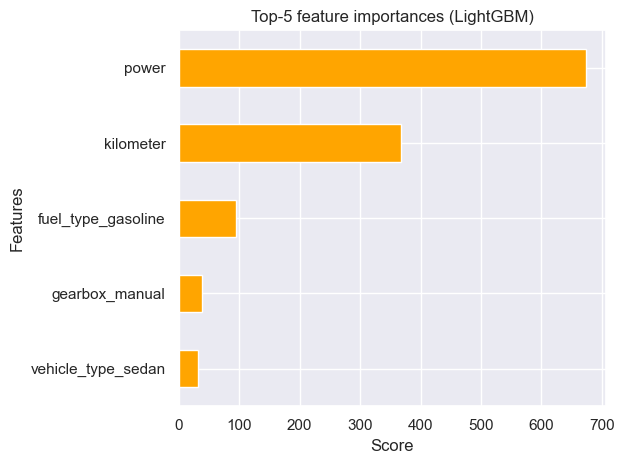

In [62]:
# Plotting feature importances
feature_importances = pd.Series(
    final_model["model"].feature_importances_,
    index=final_model["preprocessor"].get_feature_names_out(),
).sort_values()

feature_importances.tail().plot(kind="barh", color="orange")

plt.title(f"Top-5 feature importances (LightGBM)")
plt.ylabel("Features")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

**Summary**

In this small section we have seen that `kilometer` and `power` features are particularly important when predicting car prices.

# Testing

Let's check the model for predictive quality and adequacy on the test set.

In [63]:
# Testing the final model
preds = final_model.predict(features_test)
rmse_test = mean_squared_error(target_test, preds, squared=False)
assert rmse_test < RMSE_THRESHOLD, "Model quality is insufficient"

print(f"Test RMSE: {rmse_test:.2f}")

Test RMSE: 2372.71


In [64]:
# Comparing with dummy model
dummy_model = DummyRegressor(strategy="median")
dummy_model.fit(features_train, target_train)
predictions_dummy = dummy_model.predict(features_test)
rmse_dummy = mean_squared_error(predictions_dummy, target_test, squared=False)

assert rmse_test < rmse_dummy, "Model is inadequate"

print(f"Dummy test RMSE (median): {rmse_dummy:.2f}")

Dummy test RMSE (median): 4997.23


The model passed all checks so we can now save the trained model in a file.

In [65]:
# Saving the final model
dump(final_model, "car_price_prediction_model.joblib")

['car_price_prediction_model.joblib']

# Predicting new data

We can now use the saved model for making predictions on the new data. For that, let's first load the model.

In [66]:
# Loading the model
model = load("car_price_prediction_model.joblib")

Next, we will define some features of a hypothetical car, the price of which we would like to determine.

In [67]:
# Defining new data for prediction
new_data = pd.DataFrame(
    data={
        "vehicle_type": "sedan",
        "gearbox": "auto",
        "power": 200,
        "model": "3er",
        "kilometer": 100000,
        "fuel_type": "petrol",
        "brand": "bmw",
        "repaired": "yes",
    },
    index=[0],
)

display(new_data)

,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,sedan,auto,200,3er,100000,petrol,bmw,yes


In [68]:
# Displaying the prediction made
car_price_predicted = model.predict(new_data)
print(f"Price of the car: {car_price_predicted[0]:.2f} EUR")

Price of the car: 8896.58 EUR


# Final conclusion

This study was devoted to building and selecting the optimal model for determining the cost of the car. The data was uploaded, analyzed and visualized, as well as preprocessed. Moreover, the data was appropriately prepared using transformers and pipelines for machine learning algorithms and hyperparameter selection, as a result of which we were able to identify the optimal model that meets the customer's requirements.

In the process of searching for a model, two classes of models were considered: conventional machine learning models and gradient boosting models. Based on the results of a random search for optimal combinations of hyperparameters, the choice fell on the *LightGBM* model from the `lightgbm` library, which not only was able to pass the test for compliance with proper quality and sanity, but also showed good results in terms of speed and training time/predictions.